In [1]:
from train_model import *

In [29]:
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
run_name = '0702_env_1'
model_to_load='last'

In [4]:
path_to_config = f"{modeldir}{run_name}/config.json"
with open(path_to_config, "r") as f: config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}
log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']

In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")

DEVICE: cuda


In [6]:
train_data, val_data, model, optimizer, multimodal, autoencoder = setup_model(
    env_model=env_model,
    sat_model=sat_model,
    dataset=dataset,
    random_bg=random_bg,
    embed_shape=embed_shape, 
    learning_rate=learning_rate, 
    weight_decay=weight_decay,
    seed=seed) 


Making patch providers with size=1x1, flatten=False for covariates:
	 - data/GLC23/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/

Making dataset for training occurrences
nb items = 2856818
input shape: [(19, 1, 1)]

Making dataset for validation occurrences
nb items = 7438

Making model


In [7]:
checkpoint = torch.load(f"{modeldir}{run_name}/best_val_auc.pth")
model = model.to(dev)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [8]:
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=num_workers_val)
model.eval()
labels_list, y_pred_list = [], []
for inputs, _, labels in tqdm(val_loader):
    labels = labels.to(torch.float32).to(dev) 
    labels_list.append(labels.cpu().detach().numpy())

    inputs = inputs[0].to(torch.float32).to(dev)
    y_pred = torch.sigmoid(model(inputs))

    y_pred_list.append(y_pred.cpu().detach().numpy())

labels = np.concatenate(labels_list)
y_pred = np.concatenate(y_pred_list)

100%|██████████| 30/30 [01:22<00:00,  2.76s/it]


In [9]:
val_threshold = 0.5
y_bin = np.where(y_pred > val_threshold, 1, 0)

In [12]:
labels.shape

(7438, 2174)

In [20]:
site_f1 = []
for i in range(labels.shape[0]):
    site_f1.append(f1_score(labels[i,:], y_bin[i,:]))#, average='macro', zero_division=0)

In [43]:
val_df = val_data.items.copy()
val_df['n_species'] = val_df.speciesId.apply(lambda x: len(x))
val_df['F1'] = site_f1 
val_df

,lat,lon,patchID,dayOfYear,speciesId,n_species,F1
0,41.566910,9.298340,3018847,351,"[271, 4062, 644, 6510, 4190, 8994, 5727, 3800,...",19,0.045283
1,41.641550,9.259160,3018834,351,"[271, 2871, 799, 6510, 9509, 8994, 9139, 3384,...",14,0.050817
2,41.664130,9.189780,3018819,348,"[9330, 5959, 9679, 9011, 8994, 8766, 1913, 481...",27,0.046931
3,41.665690,9.165940,3018812,23,"[271, 2749, 615, 5959, 9679, 6354, 8994, 6353,...",16,0.044944
4,41.670930,9.358710,3018853,346,"[271, 4062, 4904, 799, 6510, 4190, 3649, 8994,...",17,0.058932
...,...,...,...,...,...,...,...
7433,58.581781,-4.044330,3001017,162,[9737],1,0.000000
7434,58.581813,-4.044289,3001018,162,[7904],1,0.008475
7435,58.582075,-4.042799,3001019,146,[7717],1,0.008475
7436,58.582080,-4.042799,3001019,146,"[6216, 8999, 8752, 8390]",4,0.025105


In [44]:
val_df.speciesId.apply(lambda x: len(x))

0       19
1       14
2       27
3       16
4       17
        ..
7433     1
7434     1
7435     1
7436     4
7437     2
Name: speciesId, Length: 7438, dtype: int64

<AxesSubplot: xlabel='n_species', ylabel='F1'>

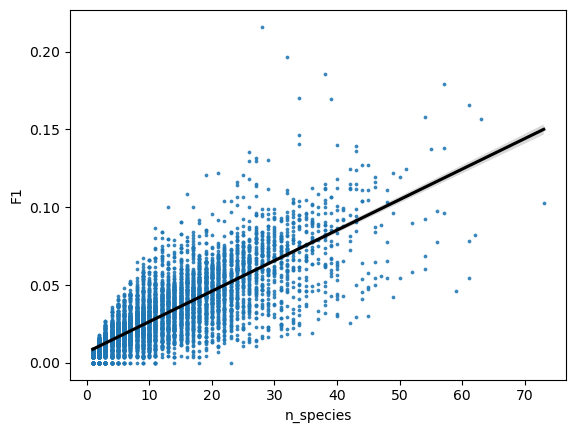

In [45]:
sns.regplot(val_df, x='n_species',y='F1',scatter_kws={'s':3},line_kws={'color':'black'})

In [46]:
val_df['F1'].quantile([0.05,0.95])

0.05    0.003774
0.95    0.074231
Name: F1, dtype: float64

<AxesSubplot: xlabel='lon', ylabel='lat'>

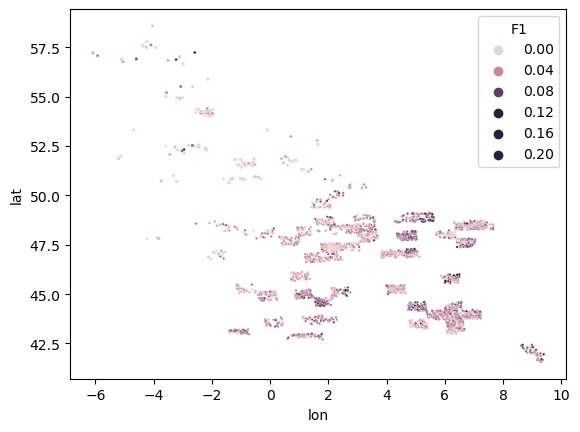

In [48]:
sns.scatterplot(val_df, x='lon',y='lat', hue='F1', s=3, hue_norm=(0.01,0.1))

In [40]:
y_pred_torch = torch.from_numpy(y_pred.T)
labels_torch = torch.from_numpy(labels.T)
auc_list = binary_auroc(y_pred_torch, labels_torch, num_tasks=labels_torch.shape[0])
auc_list.median()

tensor(0.8169, dtype=torch.float64)

In [ ]:
y_pred_torch = torch.from_numpy(y_pred)
labels_torch = torch.from_numpy(labels)
auc_list = binary_auroc(y_pred_torch, labels_torch, num_tasks=labels_torch.shape[0])
auc_list.median()

tensor(0.8363, dtype=torch.float64)

In [93]:
from sklearn.metrics import f1_score

In [111]:
y_bin = np.where(y_pred > 0.5, 1, 0)
val_f1 = f1_score(labels.T, y_bin.T, average='macro', zero_division=0)
val_f1

0.03211464173417807

tensor(0.8169, dtype=torch.float64)

In [114]:
y_pred_torch = torch.from_numpy(y_pred)
labels_torch = torch.from_numpy(labels)
auc_list = binary_auroc(y_pred_torch, labels_torch, num_tasks=labels_torch.shape[0])

In [116]:
auc_list.median()

tensor(0.8512, dtype=torch.float64)

In [41]:
from sklearn.metrics import roc_auc_score

In [42]:
roc_auc_score(labels, y_pred)

0.7661482844347376

In [88]:
len(auc_list)

2174

In [ ]:
# PA
# median lat 46 -> 643 m
# min lat 41 -> 699 m
# max lat 58 -> 490 m

# PO
# median lat 50 ->  595 m
# min lat 34 -> 767 m
# max lat 71 -> 301 m

In [4]:
from sklearn.metrics import f1_score

In [24]:
run_name = '0701_env_1_5_9_17_sat_25_59_115'
path_to_config = f"{modeldir}{run_name}/config.json"
with open(path_to_config, "r") as f: 
    config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}

log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']

In [25]:
train_data, val_data, test_data, model, optimizer, multimodal, autoencoder = setup_model(
        env_model=env_model,
        sat_model=sat_model,
        dataset=dataset,
        random_bg=random_bg,
        embed_shape=embed_shape, 
        learning_rate=learning_rate, 
        weight_decay=weight_decay,
        seed=seed,
        test=True) 


Making patch providers with size=1x1, flatten=False for covariates:
	 - data/GLC23/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/

Making patch providers with size=115x115, flatten=False for covariates:
	 - data/GLC23/SatelliteImages/

Making dataset for training occurrences
nb items = 2856818
input shape: [(19, 1, 1), (4, 116, 116)]

Making dataset for validation occurrences
nb items = 7438

Making dataset for test set
nb items = 22404

Making model


In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)
model_to_load = 'best_val_auc'
checkpoint = torch.load(f"{modeldir}{run_name}/{model_to_load}.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch'] + 1
val_auc = checkpoint['val_auc']
print(epoch, val_auc)

22 0.8238537044507194


In [123]:
run_name = '0619_env_1_5_9_17_25'
model_to_load = 'last'

In [124]:
y_pred =  np.load(f"models/{run_name}/y_pred_{model_to_load}.npy")
labels = np.load(f"models/{run_name}/y_true.npy")

In [125]:
y_bin = np.where(y_pred > 0.5, 1, 0)
f1_score(labels.T, y_bin.T, average='micro', zero_division=0).round(4)

0.0299

In [126]:
for n in [30]:#,50,100,300]:
    zeros = np.zeros(y_pred.shape)
    for i in range(y_pred.shape[0]):
        thresh = y_pred[i,:][np.argsort(y_pred[i,:])[-n]]
        zeros[i,:] = y_pred[i,:] >= thresh
    print(f"n_species = {n} -> F1 = {f1_score(labels.T, zeros.T, average='micro', zero_division=0).round(4)}")

n_species = 30 -> F1 = 0.0181


In [ ]:
y_30 = np.apply_along_axis(lambda x: [1 if i in np.argsort(x)[-30:] else 0 for i in range(len(x))], 1, y_pred)

In [19]:
f1_scores = []
thresholds = np.arange(0.05, 1, 0.05)
for thresh in tqdm(thresholds):
    y_bin = np.where(y_pred > thresh, 1, 0)
    f1_scores.append(f1_score(labels.T, y_bin.T, average='macro', zero_division=0))


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


In [49]:
y_30 = np.apply_along_axis(lambda x: [1 if i in np.argsort(x)[-30:] else 0 for i in range(len(x))], 1, y_pred)

KeyboardInterrupt: 

In [43]:
[1 if i in np.argsort(y_pred[:,i])[-30:] else 0 for i in range(len(y_pred[:,i]))]

IndexError: index 2174 is out of bounds for axis 1 with size 2174

In [29]:
t = y_pred[:,0]

In [31]:
t[np.argsort(t)]

array([0.0116761 , 0.01479814, 0.01866934, ..., 0.6935823 , 0.725114  ,
       0.75911665], dtype=float32)

In [39]:
range(len(t))

range(0, 7438)

In [41]:
pred_30 = [1 if i in np.argsort(t)[-30:] else 0 for i in range(len(t))]

In [6]:
model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [7]:
model.layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [2]:
run_name = '0604_env1_1'
path_to_config = f"{modeldir}{run_name}/config.json"
with open(path_to_config, "r") as f: 
    config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}

log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']

In [3]:
train_data, val_data, model, optimizer, multimodal, autoencoder = setup_model(
    env_model=env_model,
    sat_model=sat_model,
    dataset=dataset,
    random_bg=random_bg,
    embed_shape=embed_shape, 
    learning_rate=learning_rate, 
    weight_decay=weight_decay,
    seed=seed) 


Making patch providers with size=1x1, flatten=False for covariates:
	 - data/GLC23/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/GLC23/EnvironmentalRasters/Soilgrids/
	 - data/GLC23/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making dataset for training occurrences
nb items = 2832979
input shape: [(41, 1, 1)]

Making dataset for validation occurrences
nb items = 6218

Making model


In [4]:
val_data.items

,lat,lon,patchID,speciesId
0,41.566910,9.298340,3018847,"[271, 4062, 644, 6510, 4190, 8994, 5727, 3800,..."
1,41.641550,9.259160,3018834,"[271, 2871, 799, 6510, 9509, 8994, 9139, 3384,..."
2,41.664130,9.189780,3018819,"[9330, 5959, 9679, 9011, 8994, 8766, 1913, 481..."
3,41.665690,9.165940,3018812,"[271, 2749, 615, 5959, 9679, 6354, 8994, 6353,..."
4,41.670930,9.358710,3018853,"[271, 4062, 4904, 799, 6510, 4190, 3649, 8994,..."
...,...,...,...,...
6213,58.581781,-4.044330,3001017,[9737]
6214,58.581813,-4.044289,3001018,[7904]
6215,58.582075,-4.042799,3001019,[7717]
6216,58.582080,-4.042799,3001019,"[6216, 8999, 8752, 8390]"


In [5]:
po = pd.read_csv('data/GLC23/Presence_only_occurrences/Presences_only_train.csv', sep=';')
po.columns

Index(['glcID', 'gbifID', 'observer', 'datasetName', 'date', 'dayOfYear',
       'year', 'lon', 'lat', 'x_EPSG3035', 'y_EPSG3035', 'geoUncertaintyInM',
       'speciesId', 'patchID', 'timeSerieID'],
      dtype='object')

In [6]:
po.shape

(4908319, 15)

In [7]:
po.drop_duplicates(['lon', 'lat','patchID']).shape

(3970353, 15)

In [6]:
pa = pd.read_csv('data/GLC23/Presence_Absence_surveys/Presences_Absences_train.csv', sep=';')
pa

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
0,5140269,3.473385e+09,(IGN),Inventaire forestier IGN,2018-01-31,31,2018,7.300790,48.29273,4.120673e+06,2.801353e+06,1.0,6574,3018575,3980325
1,5279421,3.474159e+09,(IGN),Inventaire forestier IGN,2017-07-19,200,2017,1.483390,42.92599,3.625340e+06,2.241565e+06,1.0,6574,3011783,3980331
2,5058088,3.475680e+09,(IGN),Inventaire forestier IGN,2017-09-26,269,2017,6.739570,47.39633,4.074778e+06,2.703502e+06,1.0,6574,3018192,3980335
3,5146840,3.476162e+09,(IGN),Inventaire forestier IGN,2017-09-20,263,2017,4.587140,45.40615,3.897015e+06,2.492494e+06,1.0,6574,3015541,3980336
4,5255062,3.475124e+09,(IGN),Inventaire forestier IGN,2019-09-18,261,2019,6.955830,47.74829,4.092660e+06,2.741886e+06,1.0,6574,3018391,3980351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85320,5320539,NaN,NaN,CBNMed,1621461600,140,2021,5.094570,44.18660,3.928254e+06,2.354689e+06,10.0,9456,76900,3993145
85321,5392608,NaN,NaN,CBNMed,1497909600,171,2017,5.781197,43.74345,3.980545e+06,2.302273e+06,10.0,9456,94452,3986894
85322,5353058,NaN,NaN,CBNMed,1621461600,140,2021,5.094620,44.18680,3.928259e+06,2.354711e+06,10.0,9456,76905,3993923
85323,5102872,2.907311e+09,"Shoesmith, J. Judith",Nat. plant monitoring UK,2017-06-07,158,2017,0.785642,51.70740,3.686016e+06,3.217623e+06,7.1,6081,3010687,3990777


In [15]:
pa.columns

Index(['glcID', 'gbifID', 'observer', 'datasetName', 'date', 'dayOfYear',
       'year', 'lon', 'lat', 'x_EPSG3035', 'y_EPSG3035', 'geoUncertaintyInM',
       'speciesId', 'patchID', 'timeSerieID'],
      dtype='object')

In [24]:
pa[['lat','lon','patchID']].drop_duplicates()

,lat,lon,patchID
0,48.292730,7.300790,3018575
1,42.925990,1.483390,3011783
2,47.396330,6.739570,3018192
3,45.406150,4.587140,3015541
4,47.748290,6.955830,3018391
...,...,...,...
85001,51.507310,-1.038342,3007054
85018,51.507315,-1.038342,3007054
85024,51.549720,-0.689491,3007937
85047,52.484330,-2.577664,3003681


In [15]:
pa_random_sample = df[df.surveyId.isin(df.surveyId.drop_duplicates().sample(frac=0.2))]
pa_random_sample.to_csv('data/GLC24/PresenceAbsenceSurveys/GLC24-PA-metadata-train-sample-20percent.csv', index=False)

In [14]:
df[df.country != 'France'].to_csv('data/GLC24/PresenceAbsenceSurveys/GLC24-PA-metadata-train-notFrance.csv', index=False)

In [9]:
df.drop_duplicates('surveyId').groupby('region').surveyId.count().sort_values()

region
BLACK SEA            8
STEPPIC             12
BOREAL              73
PANNONIAN          219
ALPINE            1838
MEDITERRANEAN     7333
ATLANTIC         36357
CONTINENTAL      43147
Name: surveyId, dtype: int64

In [4]:
df.surveyId.drop_duplicates()

0              212
16             222
21             243
35             324
41             333
            ...   
1483581    3919553
1483592    3919592
1483596    3919620
1483608    3919640
1483621    3919655
Name: surveyId, Length: 88987, dtype: int64

In [5]:
df[df.country == 'France'].surveyId.drop_duplicates()

0              212
35             324
41             333
72             410
319            779
            ...   
1482927    3917824
1483015    3917969
1483185    3918259
1483343    3918699
1483378    3918720
Name: surveyId, Length: 13501, dtype: int64

In [2]:
y_true = np.load('models/0527_glc24_env_1/val_y_true.npy')

In [3]:
y_pred = np.load('models/0527_glc24_env_1/last_val_y_pred.npy')

In [4]:
y_true.shape

(88987, 9709)

In [5]:
y_pred.shape

(88987, 9709)

In [8]:
y_true.sum(axis=0).shape

(9709,)

In [9]:
y_true2 = y_true[:,y_true.sum(axis=0) != 0]
y_true2.shape

(88987, 4367)

In [10]:
y_pred2 = y_pred[:,y_true.sum(axis=0) !=0]
y_pred2.shape

(88987, 4367)

In [11]:
roc_auc_score(y_true2, y_pred2)

KeyboardInterrupt: 

In [ ]:
[' '.join([str(x) for x in targets[np.where(y_pred[i, :] > best_threshold)]]) for i in range(y_pred.shape[0])]

In [ ]:
[i for i in range(y_pred.shape[0])]

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [37]:
po =  pd.read_csv('data/full_data/Presence_only_occurrences/Presences_only_train.csv', sep=";", header='infer', low_memory=False)
po.shape

(4908319, 15)

In [5]:
po24 = pd.read_csv('data/glc24_data/PresenceOnlyOccurrences/GLC24-PO-metadata-train.csv')
po24.shape

(5079797, 12)

In [6]:
po_geo = gpd.GeoDataFrame(po, geometry=gpd.points_from_xy(po.lon, po.lat), crs="EPSG:4326")
po24_geo = gpd.GeoDataFrame(po24, geometry=gpd.points_from_xy(po24.lon, po24.lat), crs="EPSG:4326")

In [15]:
pa = pd.read_csv(pa_path, sep=";", header='infer', low_memory=False)
items = pd.DataFrame(pa.groupby(['lat','lon','patchID','dayOfYear'])['speciesId'].agg(list)).reset_index()
print(pa.shape, items.shape)

(85325, 15) (7438, 5)


In [18]:
pa24 = pd.read_csv('data/glc24_data/PresenceAbsenceSurveys/GLC24-PA-metadata-train.csv')
items24 = pd.DataFrame(pa24.groupby(['lat','lon','year','surveyId'])['speciesId'].agg(list)).reset_index()
print(pa24.shape, items24.shape)

(1483637, 9) (88987, 5)


In [42]:
len(pa24.speciesId.unique())

5016

In [43]:
po24[po24['speciesId'].isin(pa24.speciesId.unique())].shape

(4663657, 13)

In [22]:
pa_geo = gpd.GeoDataFrame(items, geometry=gpd.points_from_xy(items.lon, items.lat), crs="EPSG:4326")
pa24_geo = gpd.GeoDataFrame(items24, geometry=gpd.points_from_xy(items24.lon, items24.lat), crs="EPSG:4326")

<AxesSubplot: >

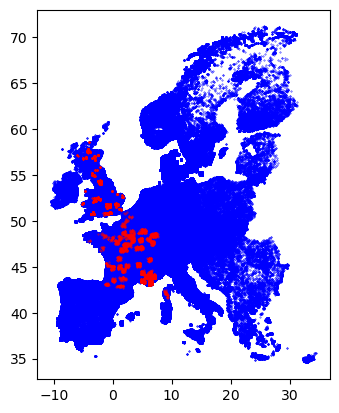

In [29]:
fig, (ax1) = plt.subplots(1)
po_geo.plot(color='blue', marker='o', markersize=0.1, ax=ax1)
pa_geo.plot(color='red', marker='o', markersize=0.1, alpha=1, ax=ax1)

# po_geo[0:100000].plot(color='red', marker='o', markersize=0.1, alpha=0.1, ax=ax)

In [113]:
po =  pd.read_csv(po_path, sep=";", header='infer', low_memory=False)
po = gpd.GeoDataFrame(po, geometry=gpd.points_from_xy(po.x_EPSG3035, po.y_EPSG3035, crs="EPSG:3035"))
po

,Unnamed: 0,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID,geometry
0,2649153,1399463,3.949786e+09,NaN,Pl@ntNet observations,2021-07-27,208,2021,8.871302,47.49095,4235890.0,2709242.0,65.00,8136,5435098,2410703,POINT (4235890.000 2709242.000)
1,4002343,1470399,2.977415e+09,NaN,Pl@ntNet automatic,2020-05-06,127,2020,12.068050,42.08209,4492705.0,2111036.0,15.17,3097,6265398,3243038,POINT (4492705.000 2111036.000)
2,2029213,1529540,2.977662e+09,NaN,Pl@ntNet automatic,2020-07-01,183,2020,6.720335,46.11742,4067272.0,2561639.0,5.00,7262,4950564,1926756,POINT (4067272.000 2561639.000)
3,1853144,401365,2.815231e+09,Ove Sander Førland;Leiv Krumsvik,NOR Species Observation,2020-06-24,176,2020,6.081810,58.98705,4095400.0,3993561.0,5.00,9687,4789398,1765663,POINT (4095400.000 3993561.000)
4,4762061,4510550,3.957207e+09,NaN,Pl@ntNet automatic,2020-05-24,145,2020,19.806660,50.06323,5020841.0,3041419.0,9.20,1995,6872516,3852177,POINT (5020841.000 3041419.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558521,1250943,1157288,3.320838e+09,David Delon,iNaturalist RG,2021-05-12,132,2021,3.730108,43.78989,3815796.0,2318978.0,3.00,8893,4216446,1196033,POINT (3815796.000 2318978.000)
3558522,2733577,715294,2.895347e+09,Miljøstyrelsen,DEN Environmental Portal,2018-08-23,235,2018,9.066010,56.38362,4263259.0,3698170.0,3.00,9407,5485782,2461471,POINT (4263259.000 3698170.000)
3558523,4753256,2799812,3.958016e+09,NaN,Pl@ntNet automatic,2020-07-30,212,2020,19.273600,50.22742,4980762.0,3054607.0,4.29,4466,6864916,3844571,POINT (4980762.000 3054607.000)
3558524,833493,3232158,2.644453e+09,NaN,Pl@ntNet automatic,2019-03-08,67,2019,1.090096,43.60787,3601788.0,2320443.0,14.61,6764,3806993,788803,POINT (3601788.000 2320443.000)


In [114]:
pa = pd.read_csv(pa_path, sep=";", header='infer', low_memory=False)
pa = gpd.GeoDataFrame(pa, geometry=gpd.points_from_xy(pa.x_EPSG3035, pa.y_EPSG3035, crs="EPSG:3035"))
pa

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID,geometry
0,5140269,3.473385e+09,(IGN),Inventaire forestier IGN,2018-01-31,31,2018,7.300790,48.29273,4.120673e+06,2.801353e+06,1.0,6574,3018575,3980325,POINT (4120673.000 2801353.000)
1,5279421,3.474159e+09,(IGN),Inventaire forestier IGN,2017-07-19,200,2017,1.483390,42.92599,3.625340e+06,2.241565e+06,1.0,6574,3011783,3980331,POINT (3625340.000 2241565.000)
2,5058088,3.475680e+09,(IGN),Inventaire forestier IGN,2017-09-26,269,2017,6.739570,47.39633,4.074778e+06,2.703502e+06,1.0,6574,3018192,3980335,POINT (4074778.286 2703501.663)
3,5146840,3.476162e+09,(IGN),Inventaire forestier IGN,2017-09-20,263,2017,4.587140,45.40615,3.897015e+06,2.492494e+06,1.0,6574,3015541,3980336,POINT (3897015.000 2492494.000)
4,5255062,3.475124e+09,(IGN),Inventaire forestier IGN,2019-09-18,261,2019,6.955830,47.74829,4.092660e+06,2.741886e+06,1.0,6574,3018391,3980351,POINT (4092660.000 2741886.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85320,5320539,NaN,NaN,CBNMed,1621461600,140,2021,5.094570,44.18660,3.928254e+06,2.354689e+06,10.0,9456,76900,3993145,POINT (3928254.000 2354689.000)
85321,5392608,NaN,NaN,CBNMed,1497909600,171,2017,5.781197,43.74345,3.980545e+06,2.302273e+06,10.0,9456,94452,3986894,POINT (3980545.000 2302273.000)
85322,5353058,NaN,NaN,CBNMed,1621461600,140,2021,5.094620,44.18680,3.928259e+06,2.354711e+06,10.0,9456,76905,3993923,POINT (3928259.000 2354711.000)
85323,5102872,2.907311e+09,"Shoesmith, J. Judith",Nat. plant monitoring UK,2017-06-07,158,2017,0.785642,51.70740,3.686016e+06,3.217623e+06,7.1,6081,3010687,3990777,POINT (3686016.000 3217623.000)


<AxesSubplot: >

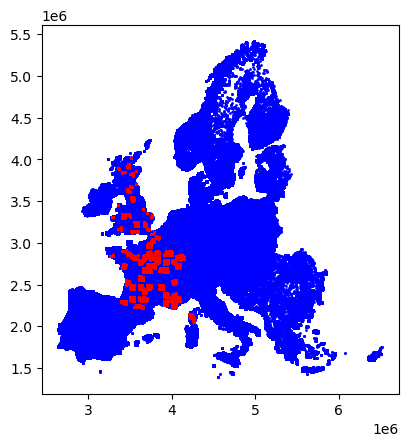

In [115]:
fig, ax = plt.subplots(1,1)
po.plot(color='blue', markersize=1, ax=ax)
pa.plot(color='red', markersize=1, ax=ax)

<AxesSubplot: >

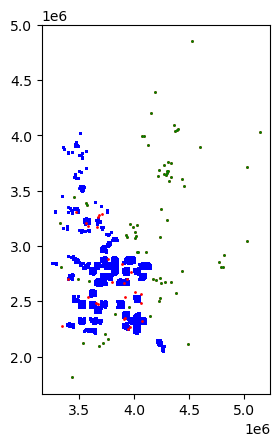

In [124]:
fig, ax = plt.subplots(1,1)
pa.plot(color='blue', markersize=1, ax=ax)
tmp.plot(color='red', markersize=1, ax=ax)
tmp[tmp['dist_to_pa'] >= 50].plot(color='green', markersize=1, ax=ax)

In [1]:
from train_model import *

In [12]:
run_name = '0527_glc24_env_1'
path_to_config = f"{modeldir}{run_name}/config.json"
with open(path_to_config, "r") as f:
    config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}

log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
n_max_low_occ = config['n_max_low_occ']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']

In [13]:
seed_everything(seed)

# get device (gpu (cuda) or cpu)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")

DEVICE: cuda


In [14]:
model_setup = {}
if env_model is not None: 
    env_model['covariates'] = [get_path_to(cov, dataset, datadir) for cov in env_model['covariates']]
    model_setup['env'] = env_model
if sat_model is not None: 
    sat_model['covariates'] = [get_path_to(cov, dataset, datadir) for cov in sat_model['covariates']]
    model_setup['sat'] = sat_model

assert len(model_setup) <= 2
multimodal = (len(model_setup) == 2)
if multimodal: assert random_bg is False
    
if list(model_setup.values())[0]['model_name'] == 'MultiResolutionAutoencoder': 
    assert multimodal == False
    autoencoder = True
else: 
    autoencoder = False

if dataset == 'glc23':
    sep = ';'
    item_columns=['lat','lon','patchID','dayOfYear']
    item_columns_val=item_columns
    sat_id_col = 'patchID'
    select_sat_train=['rgb','nir']
elif dataset == 'glc24':
    sep = ','
    item_columns=['lat','lon','surveyId','dayOfYear']
    item_columns_val=['lat','lon','surveyId']
    sat_id_col = 'surveyId'
    select_sat_train=['po_train_patches_rgb','po_train_patches_nir']
    select_sat_val=['pa_train_patches_rgb','pa_train_patches_nir']

In [15]:
train_providers = []
for model_name, model_dict in model_setup.items():
    flatten = True if model_dict['model_name'] == 'MLP' else False 
    if model_name == 'env':
        train_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten))
    elif model_name == 'sat':
        train_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten, sat_id_col, select_sat_train))

if dataset == 'glc23':
    val_providers = train_providers
elif dataset == 'glc24':
    val_providers = []
    for model_name, model_dict in model_setup.items():
        flatten = True if model_dict['model_name'] == 'MLP' else False 
        if model_name == 'env':
            val_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten))
        elif model_name == 'sat':
            val_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten, sat_id_col, select_sat_val))


Making patch providers with size=10x10, flatten=False for covariates:
	 - data/GLC24/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/GLC24/EnvironmentalRasters/Soilgrids/
	 - data/GLC24/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making patch providers with size=10x10, flatten=False for covariates:
	 - data/GLC24/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/GLC24/EnvironmentalRasters/Soilgrids/
	 - data/GLC24/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif


In [16]:
train_occ_path = get_path_to("po", dataset, datadir)
if random_bg:
    random_bg_path = get_path_to("random_bg", dataset, datadir)
else:
    random_bg_path = None
val_occ_path = get_path_to("pa", dataset, datadir)

In [17]:
train_data = PatchesDatasetCooccurrences(
    occurrences=train_occ_path, 
    providers=train_providers, 
    item_columns=item_columns,
    pseudoabsences=random_bg_path, 
    n_low_occ=n_max_low_occ,
    sep=sep
)

nb items = 3894962


In [18]:
val_data = PatchesDatasetCooccurrences(
    occurrences=val_occ_path, 
    providers=val_providers, 
    item_columns=item_columns_val,
    species=train_data.species_pred, 
    n_low_occ=n_max_low_occ,
    sep=sep
)

nb items = 88987


In [19]:
y_true.shape

(88987, 9709)

In [20]:
y_pred.shape

(88987, 9709)

In [22]:
y_true[:,val_data.species_pred_in_data].shape

(88987, 4367)

In [26]:
sps = [s for s in val_data.species_pred if s in val_data.species_data]

In [27]:
val_data.species_pred[val_data.species_pred_in_data]

array([2.0000e+00, 4.0000e+00, 9.0000e+00, ..., 1.1248e+04, 1.1253e+04,
       1.1254e+04])

In [28]:
train_data.low_occ_species

Float64Index([    1.0,     4.0,     5.0,     6.0,     8.0,    22.0,    23.0,
                 25.0,    29.0,    31.0,
              ...
              11235.0, 11238.0, 11244.0, 11245.0, 11246.0, 11248.0, 11250.0,
              11252.0, 11253.0, 11254.0],
             dtype='float64', length=6048)

In [30]:
len([s for s in val_data.species_pred[val_data.species_pred_in_data] if s in train_data.low_occ_species])

1580

In [37]:
train_data.low_occ_species

Float64Index([    1.0,     4.0,     5.0,     6.0,     8.0,    22.0,    23.0,
                 25.0,    29.0,    31.0,
              ...
              11235.0, 11238.0, 11244.0, 11245.0, 11246.0, 11248.0, 11250.0,
              11252.0, 11253.0, 11254.0],
             dtype='float64', length=6048)

In [40]:
species_pred_in_low_occ = [s in train_data.low_occ_species for s in train_data.species_pred]

In [50]:
np.logical_and(species_pred_in_low_occ, val_data.species_pred_in_data)

array([False, False, False, ..., False,  True,  True])

In [45]:
(species_pred_in_low_occ and val_data.species_pred_in_data)[0:10]

[False, False, True, True, False, False, False, True, True, True]

In [46]:
species_pred_in_low_occ[0:10]

[False, True, False, True, True, True, True, False, False, False]

In [47]:
val_data.species_pred_in_data[0:10]

[False, False, True, True, False, False, False, True, True, True]

In [36]:
np.sum([(s in train_data.low_occ_species) and (s in val_data.species_data) for s in val_data.species_pred])

1580

In [32]:
np.where(np.isin(val_data.species_pred, [s for s in val_data.species_pred[val_data.species_pred_in_data] if s in train_data.low_occ_species]))[0]

array([   3,   20,   28, ..., 9704, 9707, 9708])

In [23]:
train_data.low_occ_species

Float64Index([    1.0,     4.0,     5.0,     6.0,     8.0,    22.0,    23.0,
                 25.0,    29.0,    31.0,
              ...
              11235.0, 11238.0, 11244.0, 11245.0, 11246.0, 11248.0, 11250.0,
              11252.0, 11253.0, 11254.0],
             dtype='float64', length=6048)

In [24]:
len([s for s in val_data.species_pred if s in val_data.species_data and s in train_data.low_occ_species])

1580

In [14]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multimodal:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species_pred

In [15]:

model_list = [make_model(model_dict) for model_dict in model_setup.values()]
if multimodal:
    model = MultimodalModel(
        model_list[0], model_list[1], train_data.n_species_pred, embed_shape, embed_shape
    )
else:
    model = model_list[0]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    

In [12]:
species_pred = species
n_species_pred = len(species_pred)
print(n_species_pred)

9709


In [16]:
y_pred = np.random.rand(100, 9709)

In [18]:
np.sum([s in species_data for s in species_pred])

4367

In [ ]:
y_pred

In [13]:
items = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()
n_items = items.shape[0]
print(n_items)

88987


In [15]:
species_counts = pd.Series(
    [sps for sps_list in items[label_name] for sps in sps_list]
).value_counts().sort_index()
species_counts

2.0         31
3.0          1
4.0         37
7.0         28
9.0        240
          ... 
11245.0      3
11246.0      1
11248.0     15
11253.0     10
11254.0      9
Length: 5016, dtype: int64

In [9]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multimodal:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species
print(f"input shape: {[params['input_shape'] for params in model_setup.values()]}")

input shape: [(41, 10, 10), (4, 128, 128)]


In [10]:
test_path = 'data/full_data/For_submission/test_blind.csv'
test_data = PatchesDatasetCooccurrences(
    occurrences=test_path, 
    providers=val_providers, 
    item_columns=item_columns_val,
    species=train_data.species, 
    n_low_occ=n_max_low_occ,
    sep=sep,
    test=True
)

nb items = 22404
nb species = 2174


In [15]:
model_list = [make_model(model_dict) for model_dict in model_setup.values()]
if multimodal:
    model = MultimodalModel(model_list[0], model_list[1], train_data.n_species, embed_shape, embed_shape)
else:
    model = model_list[0]

In [16]:
model = model.to(dev)

In [12]:
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [17]:
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=batch_size)
y_pred_list = []
for inputs, _, _ in tqdm(test_loader):
        if multimodal:
                inputsA = inputs[0].to(torch.float32).to(dev)
                inputsB = inputs[1].to(torch.float32).to(dev)
                y_pred = torch.sigmoid(model(inputsA, inputsB))
        else:
                inputs = inputs[0].to(torch.float32).to(dev)
                y_pred = torch.sigmoid(model(inputs))

        y_pred_list.append(y_pred.cpu().detach().numpy())

  0%|          | 0/88 [01:18<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 23.69 GiB total capacity; 21.84 GiB already allocated; 755.94 MiB free; 22.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
y_pred =  np.load(f"models/{run_name}/y_pred_best_val_auc.npy")
y_true = np.load(f"models/{run_name}/y_true.npy")

In [12]:
from sklearn.metrics import f1_score

In [16]:
f1_scores = []
thresholds = np.arange(0, 1, 0.1)
for thresh in tqdm(thresholds):
    y_bin = np.where(y_pred > thresh, 1, 0)
    f1_scores.append(f1_score(y_true.T, y_bin.T, average='macro', zero_division=0))

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)      
print(f"Thresholds: {thresholds}\nF1-scores: {f1_scores}")
print(f"Best threshold={best_threshold} --> validation F1-score={best_f1}")

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Thresholds: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
F1-scores: [0.010335472522484386, 0.02433335559524384, 0.0291483174051465, 0.03305116032692301, 0.036607367649039664, 0.03990732596180051, 0.043020304829076185, 0.04528831431474473, 0.04576182935429596, 0.04005904737428888]
Best threshold=0.8 --> validation F1-score=0.04576182935429596


In [21]:
labels = np.random.rand(100,10)
labels = np.where(labels > 0.5, 1, 0)
y_pred = np.random.rand(100,10)

In [22]:
roc_auc_score(labels, y_pred)

0.4736077674196421

In [126]:
tmp.drop(columns=['geometry'])

,Unnamed: 0,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID,dist_to_pa
0,2649153,1399463,3.949786e+09,NaN,Pl@ntNet observations,2021-07-27,208,2021,8.871302,47.49095,4235890.0,2709242.0,65.00,8136,5435098,2410703,127.756908
1,4002343,1470399,2.977415e+09,NaN,Pl@ntNet automatic,2020-05-06,127,2020,12.068050,42.08209,4492705.0,2111036.0,15.17,3097,6265398,3243038,222.786005
2,2029213,1529540,2.977662e+09,NaN,Pl@ntNet automatic,2020-07-01,183,2020,6.720335,46.11742,4067272.0,2561639.0,5.00,7262,4950564,1926756,21.594582
3,1853144,401365,2.815231e+09,Ove Sander Førland;Leiv Krumsvik,NOR Species Observation,2020-06-24,176,2020,6.081810,58.98705,4095400.0,3993561.0,5.00,9687,4789398,1765663,547.491370
4,4762061,4510550,3.957207e+09,NaN,Pl@ntNet automatic,2020-05-24,145,2020,19.806660,50.06323,5020841.0,3041419.0,9.20,1995,6872516,3852177,899.498842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,800219,3839415,3.352642e+09,"Carruthers-Jones, I. Iain",iRecord verified,2021-05-11,131,2021,0.717243,52.24265,3688912.0,3277368.0,7.10,7017,3775658,757547,33.073848
96,376343,4154473,3.098644e+09,"Woods, A. Aaron;Gaze, M. Mark",iRecord verified,2019-05-07,127,2019,-2.442449,52.18926,3474866.0,3303604.0,70.70,9121,3373953,356351,21.782909
97,1647544,4760564,3.955929e+09,NaN,Pl@ntNet automatic,2018-08-16,228,2018,5.357560,43.27925,3943412.0,2252925.0,10.00,2404,4598899,1576907,2.473058
98,439910,3673656,3.730053e+09,NaN,Observation.org,2021-06-28,179,2021,-1.887009,42.93610,3352440.0,2280028.0,25.00,5763,3434181,416601,43.022300


In [96]:
po

,Unnamed: 0,glcID,gbifID,observer,datasetName,date,dayOfYear,year,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID,geometry
0,2649153,1399463,3.949786e+09,NaN,Pl@ntNet observations,2021-07-27,208,2021,8.871302,47.49095,4235890.0,2709242.0,65.00,8136,5435098,2410703,POINT (8.87130 47.49095)
1,4002343,1470399,2.977415e+09,NaN,Pl@ntNet automatic,2020-05-06,127,2020,12.068050,42.08209,4492705.0,2111036.0,15.17,3097,6265398,3243038,POINT (12.06805 42.08209)
2,2029213,1529540,2.977662e+09,NaN,Pl@ntNet automatic,2020-07-01,183,2020,6.720335,46.11742,4067272.0,2561639.0,5.00,7262,4950564,1926756,POINT (6.72034 46.11742)
3,1853144,401365,2.815231e+09,Ove Sander Førland;Leiv Krumsvik,NOR Species Observation,2020-06-24,176,2020,6.081810,58.98705,4095400.0,3993561.0,5.00,9687,4789398,1765663,POINT (6.08181 58.98705)
4,4762061,4510550,3.957207e+09,NaN,Pl@ntNet automatic,2020-05-24,145,2020,19.806660,50.06323,5020841.0,3041419.0,9.20,1995,6872516,3852177,POINT (19.80666 50.06323)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558521,1250943,1157288,3.320838e+09,David Delon,iNaturalist RG,2021-05-12,132,2021,3.730108,43.78989,3815796.0,2318978.0,3.00,8893,4216446,1196033,POINT (3.73011 43.78989)
3558522,2733577,715294,2.895347e+09,Miljøstyrelsen,DEN Environmental Portal,2018-08-23,235,2018,9.066010,56.38362,4263259.0,3698170.0,3.00,9407,5485782,2461471,POINT (9.06601 56.38362)
3558523,4753256,2799812,3.958016e+09,NaN,Pl@ntNet automatic,2020-07-30,212,2020,19.273600,50.22742,4980762.0,3054607.0,4.29,4466,6864916,3844571,POINT (19.27360 50.22742)
3558524,833493,3232158,2.644453e+09,NaN,Pl@ntNet automatic,2019-03-08,67,2019,1.090096,43.60787,3601788.0,2320443.0,14.61,6764,3806993,788803,POINT (1.09010 43.60787)


In [5]:
from train_model import *

In [6]:
path_to_config = 'models/0523_test_glc23/config.json'
with open(path_to_config, "r") as f:
    config = json.load(f)
config = {k: v if v != "" else None for k,v in config.items()}

In [7]:
log_wandb = config['log_wandb']
wandb_project = config['wandb_project']
wandb_id = config['wandb_id']
env_model = config['env_model']
sat_model = config['sat_model']
dataset = config['dataset']
random_bg = config['random_bg']
n_max_low_occ = config['n_max_low_occ']
embed_shape = config['embed_shape']
loss = config['loss']
lambda2 = config['lambda2']
n_epochs = config['n_epochs']
batch_size = config['batch_size']
learning_rate = config['learning_rate']
weight_decay = config['weight_decay']
num_workers_train = config['num_workers_train']
num_workers_val = config['num_workers_val']
seed = config['seed']

In [8]:
train_data, val_data, model, optimizer, multimodal, autoencoder = setup_model(
    env_model=env_model,
    sat_model=sat_model,
    dataset=dataset,
    random_bg=random_bg,
    n_max_low_occ=n_max_low_occ,
    embed_shape=embed_shape, 
    learning_rate=learning_rate, 
    weight_decay=weight_decay,
    seed=seed) 


Making patch providers with size=10x10, flatten=False for covariates:
	 - data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/

Making patch providers with size=10x10, flatten=False for covariates:
	 - data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/

Making dataset for training occurrences
nb items = 3894962
nb species = 9709
nb of species with less than 50 occurrences = 6048
input shape: [(19, 10, 10)]

Making dataset for validation occurrences
nb items = 88987
nb species = 9709
nb of species with less than 50 occurrences = 2820

Making model


In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=10)

In [6]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
    labels = labels.to(torch.float32).to(dev) 

    # forward pass
    inputsA = po_inputs[0].to(torch.float32).to(dev)
    inputsB = po_inputs[1].to(torch.float32).to(dev)
    break

  0%|          | 0/389497 [00:00<?, ?it/s]


In [7]:
y_pred = torch.sigmoid(model(inputsA, inputsB))

In [8]:
y_pred.shape

torch.Size([10, 9709])

In [13]:
model_setup = {}
if env_model is not None: 
    env_model['covariates'] = [get_path_to(cov, dataset, datadir) for cov in env_model['covariates']]
    model_setup['env'] = env_model
if sat_model is not None: 
    sat_model['covariates'] = [get_path_to(cov, dataset, datadir) for cov in sat_model['covariates']]
    model_setup['sat'] = sat_model

In [14]:
seed_everything(seed)
multimodal = (len(model_setup) == 2)
autoencoder = False
sep = ','
item_columns=['lat','lon','surveyId','dayOfYear']
item_columns_val=['lat','lon','surveyId']
sat_id_col = 'surveyId'
select_sat_train=['po_train_patches_rgb','po_train_patches_nir']
select_sat_val=['pa_train_patches_rgb','pa_train_patches_nir']

In [15]:
train_providers = []
for model_name, model_dict in model_setup.items():
    flatten = True if model_dict['model_name'] == 'MLP' else False 
    if model_name == 'env':
        train_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten))
    elif model_name == 'sat':
        train_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten, sat_id_col, select_sat_train))


Making patch providers with size=10x10, flatten=False for covariates:
	 - data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/


In [14]:
val_providers = []
for model_name, model_dict in model_setup.items():
    if model_name == 'env':
        val_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten))
    elif model_name == 'sat':
        val_providers.append(make_providers(model_dict['covariates'], model_dict['patch_size'], flatten, sat_id_col, select_sat_val))

In [14]:
train_occ_path = get_path_to("po", dataset, datadir)
if random_bg:
    random_bg_path = get_path_to("random_bg", dataset, datadir)
else:
    random_bg_path = None
val_occ_path = get_path_to("pa", dataset, datadir)

In [15]:
train_data = PatchesDatasetCooccurrences(
    occurrences=train_occ_path, 
    providers=train_providers, 
    item_columns=item_columns,
    pseudoabsences=random_bg_path, 
    n_low_occ=n_max_low_occ,
    sep=sep
)

nb items = 3894962
nb species = 9709
nb of species with less than 50 occurrences = 6048


In [16]:
train_data[0][0][1].shape

(4, 128, 128)

In [17]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multimodal:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species
print(f"input shape: {[params['input_shape'] for params in model_setup.values()]}")

input shape: [(41, 10, 10), (4, 128, 128)]


In [18]:
model_list = [make_model(model_dict) for model_dict in model_setup.values()]
model = MultimodalModel(model_list[0], model_list[1], train_data.n_species, embed_shape, embed_shape)

In [20]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=10)

In [23]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
    labels = labels.to(torch.float32).to(dev) 
    inputsA = po_inputs[0].to(torch.float32).to(dev)
    inputsB = po_inputs[1].to(torch.float32).to(dev)
    break

  0%|          | 0/389497 [00:01<?, ?it/s]


In [24]:
y_pred = torch.sigmoid(model(inputsA, inputsB))

In [25]:
y_pred

tensor([[0.4958, 0.4937, 0.5061,  ..., 0.5049, 0.5010, 0.4927],
        [0.4932, 0.4994, 0.5178,  ..., 0.5060, 0.5114, 0.5046],
        [0.5156, 0.4964, 0.5023,  ..., 0.5047, 0.4994, 0.5046],
        ...,
        [0.5056, 0.4928, 0.5064,  ..., 0.5134, 0.4963, 0.5101],
        [0.5043, 0.4939, 0.5119,  ..., 0.5066, 0.5023, 0.5044],
        [0.5091, 0.4842, 0.5096,  ..., 0.4996, 0.5042, 0.5102]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
p = train_data.providers[1][0]#[item]
patch_id = str(int(item[p.id_col]))
sub_folder_1 = patch_id[-2:]
sub_folder_2 = patch_id[-4:-2]
print(patch_id, sub_folder_1, sub_folder_2)

634179 79 41


In [70]:
select = select_sat_train
rgb_folder = [x for x in select if 'rgb' in x][0] if len([x for x in select if 'rgb' in x]) > 0 else None
nir_folder = [x for x in select if 'nir' in x][0] if len([x for x in select if 'nir' in x]) > 0 else None
print(rgb_folder, nir_folder)
channels = []
if rgb_folder is not None:
    channels += ['red','green','blue']
if nir_folder is not None:
    channels += ['nir']
# channels += [x for x in select if not ('rgb' in x or 'nir' in x)]
channel_folder = {'red': rgb_folder, 'green': rgb_folder, 'blue': rgb_folder, 'nir': nir_folder}
print(channels)
print(channel_folder)

po_train_patches_rgb po_train_patches_nir
['red', 'green', 'blue', 'nir']
{'red': 'po_train_patches_rgb', 'green': 'po_train_patches_rgb', 'blue': 'po_train_patches_rgb', 'nir': 'po_train_patches_nir'}


In [73]:
for folder in set([channel_folder[x] for x in channels]):
    path = os.path.join(p.root_path, folder, sub_folder_1, sub_folder_2, patch_id+p.ext)
    print(path)       

data/glc24_data/SatellitePatches/po_train_patches_rgb/79/41/634179.jpeg
data/glc24_data/SatellitePatches/po_train_patches_nir/79/41/634179.jpeg


In [52]:
channels

['red', 'green', 'blue', 'nir']

In [53]:
channel_folder

{'red': 'rgb', 'green': 'rgb', 'blue': 'rgb', 'nir': 'nir'}

In [45]:
select_sat_train += ['a','b']

In [49]:
[x for x in select_sat_train if not ('rgb' in x or 'nir' in x)]

[['a', 'b'], 'a', 'b']

In [36]:
p.channel_folder

{'red': 'rgb', 'green': 'rgb', 'blue': 'rgb', 'nir': 'nir'}

In [34]:
tensor_list = []
for folder in set([p.channel_folder[x] for x in p.channels]):
    print(folder)
    # path = os.path.join(self.root_path, folder, sub_folder_1, sub_folder_2, patch_id+self.ext)
    # img = np.asarray(Image.open(path))
    # if self.normalize:
    #     img = (img - self.stats[folder]['mean']) / self.stats[folder]['std']
    # if folder == 'rgb':
    #     img = img.transpose((2,0,1))
    # else:
    #     img = np.expand_dims(img, axis=0)
    # tensor_list.append(img)

KeyError: 'po_train_patches_rgb'

In [32]:
train_data.providers[1][item]

KeyError: 'po_train_patches_rgb'

In [16]:
index = 0
item = train_data.items.iloc[index][train_data.item_columns].to_dict()
item_species = train_data.items.iloc[index][train_data.label_name]
labels = 1 * np.isin(train_data.species, item_species)
# patches = [p[item] for p in train_data.providers]

In [18]:
len(train_data.providers)

2

In [25]:
p = train_data.providers[1]
p.providers

[Rasters in folder:]

In [ ]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multimodal:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species
print(f"input shape: {[params['input_shape'] for params in model_setup.values()]}")


In [24]:
val_data = PatchesDatasetCooccurrences(
    occurrences=val_occ_path, 
    providers=val_providers, 
    item_columns=item_columns_val,
    species=train_data.species, 
    n_low_occ=n_max_low_occ
)


In [58]:
model_dict = model_setup['sat']
flatten = False
# provider = make_providers(model_dict['covariates'], model_dict['patch_size'], flatten)
model_dict

{'model_name': 'MultiResolutionModel',
 'covariates': ['data/glc24_data/SatellitePatches/'],
 'patch_size': 128,
 'backbone': 'ResNet',
 'backbone_params': {'pretrained': False},
 'aspp_params': {'out_channels': 256,
  'out_size': 2174,
  'kernel_sizes': [[3, 3, 3, 3], [3, 3, 3, 3], [1]],
  'dilations': [[1, 1, 1, 1], [1, 1, 1, 1], [1]],
  'pooling_sizes': [[2, 2, 2, 2], [2, 2, 1], [1]],
  'n_linear_layers': 1}}

In [59]:
cov = model_dict['covariates'][0]
cov

'data/glc24_data/SatellitePatches/'

In [64]:
model_setup

{'env': {'model_name': 'MultiResolutionModel',
  'covariates': ['data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/',
   'data/glc24_data/EnvironmentalRasters/Soilgrids/',
   'data/glc24_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif'],
  'patch_size': 10,
  'backbone': 'CNN',
  'backbone_params': {'n_filters': [256, 256, 256, 256],
   'kernel_sizes': [1, 1, 1, 1],
   'paddings': [0, 0, 0, 0],
   'pooling_sizes': [1, 1, 1, 1]},
  'aspp_params': {'out_channels': 512,
   'out_size': 2174,
   'kernel_sizes': [[5, 5], [5], [1]],
   'dilations': [[1, 1], [1], [1]],
   'pooling_sizes': [[1, 2], [1], [1]],
   'n_linear_layers': 1}},
 'sat': {'model_name': 'MultiResolutionModel',
  'covariates': ['data/glc24_data/SatellitePatches/'],
  'patch_size': 128,
  'backbone': 'ResNet',
  'backbone_params': {'pretrained': False},
  'aspp_params': {'out_channels': 256,
   'out_size': 2174,
   'kernel_sizes': [[3, 3, 3, 3], [3, 3, 3, 3], [1]],
   'dilatio

In [63]:
JpegPatchProvider(cov, select=['po_train_patches_rgb','po_train_patches_nir'], size=128)

FileNotFoundError: [Errno 2] No such file or directory: 'data/glc24_data/SatellitePatches/po_train_patches_rgb_means.csv'

In [61]:
root_path = cov
ext = '.jpeg'
sub_dirs = next(os.walk(root_path))[1] 
sub_dirs

['pa_test_patches_nir',
 'pa_test_patches_rgb',
 'pa_train_patches_nir',
 'pa_train_patches_rgb',
 'po_train_patches_nir',
 '__MACOSX',
 'po_train_patches_rgb']

In [ ]:

        sub_dirs = next(os.walk(root_path))[1] 
        select = [x for x in select if x in sub_dirs]
        if 'rgb' in select:
            self.channels = ['red','green','blue'] + [x for x in select if x != 'rgb']
        else:
            self.channels = select
        self.channel_folder = {'red': 'rgb', 'green': 'rgb', 'blue': 'rgb','nir':'nir'}
        # 'swir1':'swir1','swir2':'swir2'

        if self.normalize:
            self.stats = {k: {
                'mean': pd.read_csv(root_path+k+'_means.csv')['mean'].values,
                'std':pd.read_csv(root_path+k+'_std.csv')['std_dev'].values
            } for k in select}

        self.nb_layers = len(self.channels)
        self.bands_names = list(self.channels)
        self.size = size

In [32]:
index = 0
item = train_data.items.iloc[index][train_data.item_columns].to_dict()
item_species = train_data.items.iloc[index][train_data.label_name]
labels = 1 * np.isin(train_data.species, item_species)

In [34]:
len(train_data.providers)

2

In [50]:
p = train_data.providers[1]

In [55]:
p.providers[0].nb_layers

0

In [49]:
patch = np.concatenate([provider[item] for provider in p.providers])
patch.shape

(41, 10, 10)

In [48]:
provider = p.providers[2]
provider[item]

array([[[-1.32917511, -1.32917511, -1.32917511, ..., -1.32917511,
         -1.32917511, -1.32917511],
        [-1.32917511, -1.32917511, -1.32917511, ..., -1.32917511,
         -1.32917511, -1.32917511],
        [-1.32917511, -1.32917511, -1.32917511, ..., -1.32917511,
         -1.32917511, -1.32917511],
        ...,
        [-1.32917511, -1.32917511, -1.32917511, ..., -1.32917511,
         -1.32917511, -1.32917511],
        [-1.32917511, -1.32917511, -1.32917511, ..., -1.32917511,
         -1.32917511, -1.32917511],
        [-1.32917511, -1.32917511, -1.32917511, ..., -1.32917511,
         -1.32917511, -1.32917511]],

       [[-0.6326931 , -0.6326931 , -0.6326931 , ..., -0.6326931 ,
         -0.6326931 , -0.6326931 ],
        [-0.6326931 , -0.6326931 , -0.6326931 , ..., -0.6326931 ,
         -0.6326931 , -0.6326931 ],
        [-0.6326931 , -0.6326931 , -0.6326931 , ..., -0.6326931 ,
         -0.6326931 , -0.6326931 ],
        ...,
        [-0.6326931 , -0.6326931 , -0.6326931 , ..., -

In [ ]:
patches = [p[item] for p in train_data.providers]

In [22]:
for i, key in enumerate(model_setup.keys()):
    print(i, key)
    model_setup[key]['input_shape'] = train_data[0][0][i].shape

0 env


ValueError: need at least one array to concatenate

In [20]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multimodal:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species
print(f"input shape: {[params['input_shape'] for params in model_setup.values()]}")


ValueError: need at least one array to concatenate

In [39]:
sep = ',' if 'glc24' in occurrences else ';'
df = pd.read_csv(occurrences, sep=sep, header='infer', low_memory=False)

In [40]:
species = np.unique(df[label_name].values)
len(species)

9709

In [41]:
df.columns

Index(['publisher', 'year', 'month', 'day', 'lat', 'lon', 'geoUncertaintyInM',
       'taxonRank', 'date', 'dayOfYear', 'speciesId', 'surveyId'],
      dtype='object')

In [43]:
df.shape

(5079797, 12)

In [34]:
items = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()
items.shape

(4007514, 5)

In [45]:
set(df.year)

{2017, 2018, 2019, 2020, 2021}

In [44]:
pd.DataFrame(df.groupby(['lat', 'lon', 'dayOfYear'])[label_name].agg(list)).reset_index().shape

(3893663, 4)

In [42]:
pd.DataFrame(df.groupby(['lat', 'lon', 'year', 'dayOfYear'])[label_name].agg(list)).reset_index().shape

(3894962, 5)

In [ ]:
for i, key in enumerate(model_setup.keys()):
        model_setup[key]['input_shape'] = train_data[0][0][i].shape
        if multimodal:
            assert embed_shape is not None
            model_setup[key]['output_shape'] = embed_shape
        else:
            model_setup[key]['output_shape'] = train_data.n_species

In [7]:
train_data, val_data, model, optimizer, multimodal, autoencoder = setup_model(
    model_setup=model_setup, 
    train_occ_path=train_occ_path, 
    random_bg_path=random_bg_path, 
    val_occ_path=val_occ_path, 
    n_max_low_occ=n_max_low_occ,
    embed_shape=embed_shape, 
    learning_rate=learning_rate, 
    weight_decay=weight_decay,
    seed=seed) 


Making patch providers with size=10x10, flatten=False for covariates:
	 - data/glc24_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/glc24_data/EnvironmentalRasters/Soilgrids/
	 - data/glc24_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif

Making patch providers with size=128x128, flatten=False for covariates:
	 - data/glc24_data/SatellitePatches/

Making dataset for training occurrences


KeyError: 'speciesId'

In [8]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

In [9]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [10]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
    labels = labels.to(torch.float32)
    inputsA = po_inputs[0].to(torch.float32).to(dev)
    inputsB = po_inputs[1].to(torch.float32).to(dev)
    break

  0%|          | 0/285682 [00:00<?, ?it/s]


In [11]:
y_pred = torch.sigmoid(model(inputsA, inputsB))

In [12]:
y_pred.shape

torch.Size([10, 2174])

In [44]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=5)
for po_inputs, bg_inputs, labels in tqdm(train_loader):
    labels = labels.to(torch.float32)
    inputs = po_inputs[0].to(torch.float32).to(dev)
    break

  0%|          | 0/571364 [00:00<?, ?it/s]


In [45]:
x = inputs
x.shape

torch.Size([5, 41, 8, 8])

In [46]:
x1 = model.backbone(x)
x1.shape

torch.Size([5, 256, 8, 8])

In [48]:
len(model.aspp_block.aspp_branches)

3

In [55]:
branches = [nn.Sequential(
            nn.Conv2d(256, 512, k), 
            nn.ReLU()).to(dev) for k in [1,3,5]]

In [56]:
x2 = [aspp(x1) for aspp in branches]
# x2 = [aspp(x1) for aspp in model.aspp_block.aspp_branches]
print([x.shape for x in x2])
x3 = [model.aspp_block.crop(xi).squeeze() for xi in x2]
print([x.shape for x in x3])
x4 = [l(xi) for xi, l in zip(x3, model.aspp_block.linear_layers)]
print([x.shape for x in x4])

[torch.Size([5, 512, 8, 8]), torch.Size([5, 512, 6, 6]), torch.Size([5, 512, 4, 4])]
[torch.Size([5, 512]), torch.Size([5, 512]), torch.Size([5, 512])]
[torch.Size([5, 2174]), torch.Size([5, 2174]), torch.Size([5, 2174])]


In [58]:
x2[0][0,0,:,:]

tensor([[0.3215, 0.4591, 0.2082, 0.3225, 0.1884, 0.1318, 0.1606, 0.1403],
        [0.3205, 0.0842, 0.0795, 0.1740, 0.1709, 0.1070, 0.1303, 0.1814],
        [0.4666, 0.2151, 0.1068, 0.1960, 0.2419, 0.1501, 0.1992, 0.2442],
        [0.2871, 0.0000, 0.3141, 0.3357, 0.2869, 0.1918, 0.0852, 0.1889],
        [0.4891, 0.0000, 0.2518, 0.3177, 0.2703, 0.1910, 0.0923, 0.1459],
        [0.2320, 0.4610, 0.0950, 0.1485, 0.2045, 0.1991, 0.2501, 0.1562],
        [0.5393, 0.6094, 0.3304, 0.2159, 0.2019, 0.1293, 0.1773, 0.2929],
        [0.1173, 0.1944, 0.2660, 0.2605, 0.2226, 0.2258, 0.2567, 0.3533]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [63]:
x3[0][0,0]

tensor(0.2703, device='cuda:0', grad_fn=<SelectBackward0>)

In [50]:
config['env_model']

{'model_name': 'MultiResolutionModel',
 'covariates': ['data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/',
  'data/full_data/EnvironmentalRasters/Soilgrids/',
  'data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif'],
 'patch_size': 8,
 'backbone_params': {'n_filters': [256, 256, 256, 256],
  'kernel_sizes': [1, 1, 1, 1],
  'paddings': [0, 0, 0, 0],
  'pooling_sizes': [1, 1, 1, 1]},
 'aspp_params': {'out_channels': 512, 'kernel_sizes': [1, 3, 5]},
 'input_shape': (41, 8, 8),
 'output_shape': 2174}

In [33]:
x2 = model.aspp_block(x1)

In [36]:
x2[0].shape

torch.Size([5, 2174])

In [8]:
providers = []
for model_dict in model_setup.values():
    flatten = True if model_dict['model_name'] == 'MLP' else False 
    providers.append(make_providers(
        model_dict['covariates'], model_dict['patch_size'], flatten
    ))


Making patch providers with size=8x8, flatten=False for covariates:
	 - data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
	 - data/full_data/EnvironmentalRasters/Soilgrids/
	 - data/full_data/EnvironmentalRasters/LandCover/LandCover_MODIS_Terra-Aqua_500m.tif


KeyboardInterrupt: 

In [ ]:
train_data = PatchesDatasetCooccurrences(
    occurrences=train_occ_path, 
    providers=providers, 
    pseudoabsences=random_bg_path, 
    n_low_occ=n_max_low_occ
)

In [ ]:
model_setup = {}
if dict['env_model'] is not None: model_setup['env'] = config['env_model']
if dict['sat_model'] is not None: model_setup['sat'] = config['sat_model']
model_setup

In [ ]:
[eval(f) for f in config['env_model']['covariates']]

In [ ]:
config['e_model']

In [ ]:
train_occ_path=po_path_sampled_25
random_bg_path=None
val_occ_path=pa_path
env_model={'model_name':'ASPP', 'covariates':[bioclim_dir, soil_dir, landcover_path], 'patch_size': 10, 'embed_shape': 64, 'kernel_sizes': [1,3,3], 'dilations': [1,1,2]}
sat_model=None
n_max_low_occ=50
embed_shape=None
loss='an_full_loss'
lambda2=None
n_epochs=100
batch_size=128
learning_rate=1e-3
seed=42

In [ ]:
model_setup = {}
if env_model is not None: model_setup['env'] = env_model
if sat_model is not None: model_setup['sat'] = sat_model
print(model_setup)

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {dev}")

In [ ]:
train_data, val_data, model, optimizer, multires = setup_model(
    model_setup, train_occ_path, random_bg_path, val_occ_path, n_max_low_occ,
    embed_shape, learning_rate, seed)
model = model.to(dev)

In [ ]:
batch_size=10
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)#, num_workers=4)

In [ ]:
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCELoss()

In [ ]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
   labels = labels.to(torch.float32).to(dev)
   inputs = po_inputs[0].to(torch.float32).to(dev)
   break

In [ ]:
y_pred = torch.sigmoid(model(inputs))

In [ ]:
y_pred.shape

In [ ]:

x = inputs
x_in = [x[:, :, imin:imax, imin:imax] for imin, imax in zip(model.imins, model.imaxs)]

In [ ]:
x_in[0].shape

In [ ]:
m = model.aspp_branches[0].to(dev)
m(x_in[0])

In [ ]:

x = [aspp(xi) for aspp, xi in zip(model.aspp_branches, x_in)]

In [ ]:
print([xi.get_device() for xi in x_in])

In [ ]:
print(model.subpatch_sizes)
print(model.center_idx)
print(model.imins)
print(model.imaxs)

In [ ]:
model.center_idx

In [ ]:
[i >= 0 for i in imins]

In [ ]:
(np.array(imaxs) < 4).all()

In [ ]:
    y_pred = torch.sigmoid(model(inputs))


In [ ]:
from torch import nn

def aspp_branch(in_channels, out_channels, kernel_size, dilation):
    '''
    As implemented in:
    https://github.com/yassouali/pytorch-segmentation/blob/master/models/deeplabv3_plus.py
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size,dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

In [ ]:
kernel_sizes = [1, 3, 3, 3]
dilations = [1, 1, 2, 3]
subpatch_sizes = [(d-1)*(k-1) + k for k, d in zip(kernel_sizes, dilations)]
print(subpatch_sizes)
in_patch_size = 8
center_idx = in_patch_size // 2
print(center_idx)

In [ ]:
in_channels = 41
out_channels = 64
aspp_branches = [aspp_branch(in_channels, out_channels, k, d) for k, d in zip(kernel_sizes, dilations)]
len(aspp_branches)

In [ ]:
x = po_inputs[0].to(torch.float32)
imins = [int(center_idx - (s-1)/2) for s in subpatch_sizes]
imaxs = [int(center_idx + (s-1)/2 + 1) for s in subpatch_sizes]
x_in = [x[:, :, imin:imax, imin:imax] for imin, imax in zip(imins, imaxs)]
x_out = [aspp(xi) for aspp, xi in zip(aspp_branches, x_in)]

In [ ]:
print([o.shape for o in x_out])

In [ ]:
x = torch.cat(x_out, dim=1).squeeze()
print(x.shape)

In [ ]:
l = nn.Linear(256, 10)
l(x).shape

In [ ]:
kernel_sizes = [1, 3, 3, 3]
dilations = [1, 1, 2, 3]
subpatch_sizes = [(d-1)*(k-1) + k for k, d in zip(kernel_sizes, dilations)]
print(subpatch_sizes)
in_patch_size = 9
center_idx = in_patch_size // 2
print(center_idx)

In [ ]:
imins = [int(center_idx - (s-1)/2) for s in subpatch_sizes]
imaxs = [int(center_idx + (s-1)/2 + 1) for s in subpatch_sizes]
x_in = [x[:, imin:imax, imin:imax] for imin, imax in zip(imins, imaxs)]
print([y.shape for y in x_in])

In [ ]:
in_channels = 41
out_channels = 128
aspp_branches = [aspp_branch(in_channels, out_channels, k, d) for k, d in zip(kernel_sizes, dilations)]

In [ ]:
xi = x_in[0].to(torch.double)
aspp = aspp_branches[0]
print(xi.shape)
print(aspp)

In [ ]:
import pdb
pdb.set_trace()
aspp(xi)

In [ ]:
x_out = [torch.rand((out_channels, 1, 1)) for i in range(5)]

In [ ]:
torch.cat(x_out, dim=0).shape

In [ ]:
item = train_data.items.iloc[0]

In [ ]:
print(f"{p.n_rows} - ({item.lat} - {p.y_min}) / {p.y_resolution})")
print(p.n_rows - (item.lat - p.y_min) / p.y_resolution)
x = int(p.n_rows - (item.lat - p.y_min) / p.y_resolution)
y = int((item.lon - p.x_min) / p.x_resolution)
print(x, y)

In [ ]:
print(f"{x} - ({p.patch_size} // 2), {x} + ({p.patch_size} // 2)")
print(x - (p.patch_size // 2), x + (p.patch_size // 2))

In [ ]:
print(f"{y} - ({p.patch_size} // 2), {y} + ({p.patch_size} // 2)")
print(y - (p.patch_size // 2), y + (p.patch_size // 2))

In [ ]:
patch_data = [p.data[i, x - (p.patch_size // 2): x + (p.patch_size // 2), y - (p.patch_size // 2): y + (p.patch_size // 2)] for i in range(p.nb_layers)]


In [ ]:
patch_data[0].shape

In [ ]:
x = np.array([1,2,3,4,5,7,5,8,4,7,3,67,3,2,8,3,5,7,2,6,5,6])
x[3:8]

In [ ]:
4511-4447

In [ ]:
for i, key in enumerate(model_setup.keys()):
    model_setup[key]['input_shape'] = train_data[0][0][i].shape
    if multires:
        assert embed_shape is not None
        model_setup[key]['output_shape'] = embed_shape
    else:
        model_setup[key]['output_shape'] = train_data.n_species
print([[m['input_shape'], m['output_shape']] for m in model_setup.values()])

In [ ]:
val_data = PatchesDatasetCooccurrences(
    occurrences=val_occ_path,
    providers=providers, 
    species=train_data.species, 
    n_low_occ=n_max_low_occ
)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)#, num_workers=4)

In [ ]:
model_list = [make_model(model_dict) for model_dict in model_setup.values()]
if multires:
    model = MultiScaleModel(
        model_list[0], model_list[1], train_data.n_species, embed_shape, embed_shape
    ).to(dev)
else:
    model = model_list[0].to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# loss functions
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights).to(dev)
val_loss_fn = torch.nn.BCELoss()

In [ ]:
arch ='resnet18'
block = BasicBlock
layers = [2, 2, 2, 2]
pretrained = False# 'ResNet18_Weights.IMAGENET1K_V1' 
progress = True

model = ResNet(block, layers, **kwargs)
    # if pretrained:
    #     state_dict = load_state_dict_from_url(model_urls[arch],
    #                                           progress=progress)
    #     model.load_state_dict(state_dict)

In [ ]:
for po_inputs, bg_inputs, labels in tqdm(train_loader):
    labels = labels.to(torch.float32).to(dev) 
    print(labels.shape)

    if multires:
        inputsA = po_inputs[0].to(torch.float32).to(dev)
        inputsB = po_inputs[1].to(torch.float32).to(dev)
        y_pred = torch.sigmoid(model(inputsA, inputsB))

    else:
        if random_bg_path is None:
            inputs = po_inputs[0].to(torch.float32).to(dev)
            print(po_inputs[0].shape)
        else:
            inputs = torch.cat((po_inputs[0], bg_inputs[0]), 0).to(torch.float32).to(dev)
            print(po_inputs[0].shape, len(po_inputs))
            print(len(bg_inputs), bg_inputs[0].shape)
            print(inputs.shape)
        y_pred = torch.sigmoid(model(inputs))
            
    if random_bg_path is None:
       train_loss = loss_fn(y_pred, labels, species_weights)
          
    else:
        po_pred = y_pred[0:len(po_inputs[0])]
        bg_pred = y_pred[len(po_inputs[0]):]        
        train_loss = loss_fn(po_pred, labels, species_weights, lambda2, bg_pred)

    print(train_loss)
    break

In [ ]:
torch.sigmoid(model_list[0](inputsA)).min()

In [ ]:
torch.sigmoid(model_list[1](inputsB)).min()

In [ ]:
po_inputs[0].shape

In [ ]:
    
model = get_model(model, input_shape[0], n_species, model_params, patch_size).to(dev)


In [ ]:
flatten = [True if model == 'MLP' else False for model in models]
flatten

In [ ]:
providers = []
for group, patch_size, f in zip(covariates, patch_sizes, flatten):

    group_providers = []
    for cov in group:
        print(f"\t - {cov}")
        if 'SatelliteImages' in cov:
            if f and patch_size != 1: 
                exit("jpeg patch provider for satellite images cannot flatten image patches")
            group_providers.append(JpegPatchProvider(cov, size=patch_size))
        elif '.tif' in cov:
            group_providers.append(RasterPatchProvider(cov, size=patch_size, flatten=f))
        else:
            group_providers.append(MultipleRasterPatchProvider(cov, size=patch_size, flatten=f))

    providers.append(group_providers)

In [ ]:
train_data = MultiScalePatchesDatasetCooccurrences(occurrences=train_occ_path, providersA=providers[0], providersB=providers[1])

In [ ]:
tmp = train_data[0]

In [ ]:
index = 0
item = train_data.items.iloc[index][train_data.item_columns].to_dict()
item_species = train_data.items.iloc[index][train_data.label_name]
labels = 1 * np.isin(train_data.species, item_species)
labels

In [ ]:
next(iter(train_loader))

In [ ]:
tmp = train_data[0]

In [ ]:
tmp[1].shape

In [ ]:
input_shapes = [input.shape for input in train_data[0][0]]
n_species = train_data.n_species
print(f"input shape = {input_shapes}")

In [ ]:
n_max_low_occ = 50
low_occ_species = train_data.species_counts[train_data.species_counts <= n_max_low_occ].index
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))[0]
print(f"nb of species with less than {n_max_low_occ} occurrences = {len(low_occ_species_idx)}")

In [ ]:
val_data = MultiScalePatchesDatasetCooccurrences(occurrences=val_occ_path, providers=providers, species=train_data.species)

In [ ]:
batch_size = 2
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [ ]:
modelA = MLP(input_shapes[0][0], 512, 5, 1000)
modelB = get_resnet(512)
model = MultiScaleModel(modelA, modelB, 512, 512, n_species)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = eval(loss)
species_weights = torch.tensor(train_data.species_weights)
val_loss_fn = torch.nn.BCELoss()

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch[0][0].shape

In [ ]:
(inputsA, inputsB), labels = batch
print(inputsA.shape, inputsB.shape, labels.shape)

In [ ]:
inputsA = inputsA.to(torch.float32)
inputsB = inputsB.to(torch.float32)
out = model(inputsA, inputsB)

In [ ]:
out = torch.sigmoid(out)

In [ ]:
out.shape

In [ ]:
1e-28 + 1e-05 * np.abs(p.nodata_value[0])

In [ ]:
plt.imshow(np.where(np.isclose(p.data, p.nodata_value[0], atol=1e-8), np.nan, p.data)[0,3500:4000,3000:4000])

In [ ]:
p_soil.rasters_providers[0].nodata_value

In [ ]:
for p in p_bioclim.rasters_providers[1:]:
    pseudoabsence_locations += np.where(p.data != 0, 1, 0)


In [ ]:
np.sum(np.where(pseudoabsence_locations != 0, 1, 0))

In [ ]:
5467*8143

In [ ]:
for p in p_bioclim.rasters_providers:
    print(f"{p.name}: xmin={p.x_min} / ymin={p.y_min} / nrows={p.n_rows} / ncold={p.n_cols} / nlayers={p.nb_layers}")

In [ ]:
for p in p_soil.rasters_providers:
    print(f"{p.name}: xmin={p.x_min} / ymin={p.y_min} / nrows={p.n_rows} / ncold={p.n_cols} / nlayers={p.nb_layers}")

In [ ]:
# patch_size = 1
# flatten = True 
# p_bioclim = MultipleRasterPatchProvider(bioclim_dir, size=patch_size, flatten=flatten) 
# p_soil = MultipleRasterPatchProvider(soil_dir, size=patch_size, flatten=flatten) 
# p_landcover = RasterPatchProvider(landcover_dir, size=patch_size, flatten=flatten)
p_sat = JpegPatchProvider(sat_dir, size = 128)

In [ ]:
train_data = PatchesDatasetCooccurrences(occurrences=po_path, providers=(p_sat))
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")
print(train_data[0][0].shape, train_data[0][1].shape)

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

val_data = PatchesDatasetCooccurrences(occurrences=pa_path, providers=(p_sat), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")
print(val_data[0][0].shape, val_data[0][1].shape)

In [ ]:
low_occ_species = train_data.species_counts[train_data.species_counts < 50].index
low_occ_species

In [ ]:
low_occ_species_idx = np.where(np.isin(train_data.species, low_occ_species))

In [ ]:
low_occ_species_idx[0].shape

In [ ]:
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=1024)
labels_list = []
for inputs, labels in tqdm(val_loader):
    labels_list.append(labels.numpy())
labels = np.concatenate(labels_list)
print(labels.shape)

In [ ]:
labels[:, low_occ_species_idx].shape

In [ ]:
pred = torch.rand(labels.shape).numpy()
pred.shape

In [ ]:
roc_auc_score(labels, pred)

In [ ]:
roc_auc_score(labels[:, low_occ_species_idx], pred[:, low_occ_species_idx])

In [ ]:
.shape

In [ ]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
weights = model.conv1.weight.data.clone()
model.conv1 = torch.nn.Conv2d(6, 64, kernel_size=(7,7), stride=(2,2),
                              padding=(3,3), bias=False)
# first three bands are RGB
model.conv1.weight.data[:, :3, :, :] = weights

In [ ]:
model.conv1.weight.data.size()

In [ ]:
model.conv1.weight.data[:, 3:, :, :].size()

In [ ]:
weights[:,0,:,:].repeat((3,1,1,1)).reshape((64,3,7,7))[0,:,:,0]

In [ ]:
weights[0,0,:,0]

In [ ]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
weights = model.conv1.weight.data.clone()
model.conv1 = torch.nn.Conv2d(len(p_sat.bands_names), 64, kernel_size=(7,7), stride=(2,2),
                              padding=(3,3), bias=False)
# first three bands are RGB
model.conv1.weight.data[:, :3, :, :] = weights
# initialize weights for 4th band (NIR) to pretrained weights for R
model.conv1.weight.data[:,-1,:,:] = weights[:,0,:,:]
model.fc = torch.nn.Linear(512, n_species)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

In [ ]:
for inputs, labels in train_loader:
    print('-----------------------')
    inputs = inputs.to(torch.float32)
    labels = labels.to(torch.float32)

    print(inputs.size())
    print(labels.size())
    pred = model(inputs)
    print(pred.size())
    pred_sigmoid = torch.sigmoid(pred)
    loss = loss_fn(pred_sigmoid, labels)
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
img = (img - p_sat.stats[folder]['mean']) / p_sat.stats[folder]['std']
img[0:4,0:4]

In [ ]:
(122-77.3)/25.6
# [[140, 134, 122],
# [130, 124, 110],
# [126, 118, 105],
# [131, 123, 110]]]

# {'rgb': {'mean': array([85.53290863, 89.00972544, 77.32355934]),
#   'std': array([28.46643494, 25.3613768 , 25.57295764])},

In [ ]:

        tensor_list = []
        for folder in set([self.channel_folder[x] for x in self.channels]):
            path = os.path.join(self.root_path, folder, sub_folder_1, sub_folder_2, patch_id+self.ext)
            img = np.asarray(Image.open(path))
            if self.normalize:
                img = (img - self.stats[folder]['mean']) / self.stats[folder]['std']
            if folder == 'rgb':
                img = img.transpose((2,0,1))
            else:
                img = np.expand_dims(img, axis=0)
            tensor_list.append(img)

        tensor = np.concatenate(tensor_list)   

In [ ]:
n_layers=5
width=1000
learning_rate = 1e-3

checkpoint = torch.load(f"models/0129_MLP_env_1x1_an_slds/last.pth") 
model = MLP(n_features, n_species, n_layers, width).to(dev)
model.load_state_dict(checkpoint['state_dict'])

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
batch_size = 100
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [ ]:
model.eval()
for inputs, labels in tqdm(val_loader):

    inputs = inputs.to(torch.float32).to(dev)
    labels = labels.to(torch.float32).to(dev) 

    y_pred = model(inputs)
    y_pred_sigmoid = torch.sigmoid(y_pred)
    break

In [ ]:
from util import full_weighted_loss, log_loss, an_slds_loss

In [ ]:
site_loss = ((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).sum(axis=1)
site_loss

In [ ]:
site_weight = 1 / (labels.sum(axis=1) + 1e-5)
site_weight

In [ ]:
(site_loss * site_weight)

In [ ]:
labels.sum(axis=1)

In [ ]:
((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).size()

In [ ]:
torch.transpose((1/labels.sum(axis=1)).repeat((970,1)), 0, 1).size()

In [ ]:
y_pred_sigmoid = torch.sigmoid(y_pred)

In [ ]:
((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels)))

In [ ]:
per_site_loss = ((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))) * torch.transpose((1/labels.sum(axis=1)).repeat((970,1)), 0, 1)

In [ ]:
((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).sum(axis=1).size()

In [ ]:
(1/labels.sum(axis=1)).size()

In [ ]:
site_loss = ((log_loss(y_pred_sigmoid) * labels) + (log_loss(1 - y_pred_sigmoid) * (1 - labels))).sum(axis=1)
site_weight = (1/labels.sum(axis=1))
print(site_loss.size(), site_weight.size())

In [ ]:
(site_loss * site_weight).mean()

In [ ]:
per_site_loss.sum() 

In [ ]:
species_weights = torch.tensor(train_data.species_weights)
species_weights.size()

In [ ]:
(log_loss(pred) * labels).shape# * species_weights.repeat((batch_size, 1))).mean()


In [ ]:
pred * labels

In [ ]:
np.ones(labels.shape[1]).shape

In [ ]:
labels.shape

In [ ]:
species_weights = torch.tensor(train_data.species_weights.values)

In [ ]:
species_weights.repeat((100,1)).size()

In [ ]:
species_weights

In [ ]:
(species_weights/(species_weights-1)).repeat((batch_size,1)).size()

In [ ]:
index = 0 
item_columns=['lat','lon','patchID','dayOfYear']
train_data.items.iloc[index][item_columns].to_dict()

In [ ]:
train_data.items.iloc[index]['speciesId']

In [ ]:
for inputs, labels in tqdm(train_loader):
    print(inputs.shape, labels.shape)

In [ ]:
img.shape

In [ ]:
img[:,0:2,0:2]

In [ ]:
((img - stats[folder]['mean']) / stats[folder]['std'])[:,0:2,0:2]

In [ ]:
img_shape = np.array(Image.open(files[0], mode='r')).shape 
dims = len(img_shape)
dims

In [ ]:
img_shape

In [ ]:
sums = np.array([0.0] * img_shape[2]) if dims == 3 else np.array([0.0])
n_terms = 0

for f in files:
    img = np.array(Image.open(f, mode='r'))
    nans = np.sum(np.isnan(img))
    if nans != 0: 
        print(f)
        break
    img_sum = np.sum(img, axis=(0,1))
    sums += img_sum
    n_terms += img.shape[0] * img.shape[1]

In [ ]:
sums

In [ ]:
means = sums / n_terms
means

In [ ]:
pd.DataFrame({'mean': means}).to_csv('data/sample_data/SatelliteImages/rgb_means.csv', index=False)

In [ ]:
means = pd.read_csv('data/sample_data/SatelliteImages/rgb_means.csv')
means = np.array(means['mean'])
means

In [ ]:
sums = np.array([0.0] * img_shape[2]) if dims == 3 else np.array([0.0])
n_terms = 0

for f in files:
    img = np.array(Image.open(f, mode='r'))
    sum_dev_mean = np.sum(np.power(img - means, 2), axis=(0,1))
    sums += sum_dev_mean
    n_terms += img.shape[0] * img.shape[1]    

In [ ]:
std_devs = np.power(sums / n_terms, 0.5)
std_devs

In [ ]:
pd.DataFrame({'std_dev': std_devs}).to_csv('data/sample_data/SatelliteImages/rgb_std_devs.csv', index=False)

In [ ]:
datadir = 'data/full_data/'
bioclim_dir = datadir+'EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/'
soil_dir = datadir+'EnvironmentalRasters/Soilgrids/'
po_path = datadir+'Presence_only_occurrences/Presences_only_train_sampled_10_percent_min_100_occurrences.csv' #Presences_only_train_sampled_25_percent_min_10_occurrences.csv'
pa_path = datadir+'Presence_Absence_surveys/Presences_Absences_train.csv'

In [ ]:
occurrences=po_path
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
items = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()

In [ ]:
root_path = sat_dir
ext = '.jpeg'
sub_dirs = next(os.walk(root_path))[1]
select = [x for x in ['rgb','nir'] if x in sub_dirs]
channels = ['red','green','blue'] + [x for x in select if x != 'rgb']
channel_folder = {'red': 'rgb', 'green': 'rgb', 'blue': 'rgb','nir':'nir'}

In [ ]:
item = items.iloc[0][item_columns].to_dict()
patch_id = str(int(item['patchID']))
sub_folder_1 = patch_id[-2:]
sub_folder_2 = patch_id[-4:-2]

In [ ]:
for folder in set([channel_folder[x] for x in channels]):
    path = os.path.join(root_path, folder, sub_folder_1, sub_folder_2, patch_id+ext)
    print(folder, path)
    
    img = np.asarray(Image.open(path))
    if folder == 'rgb':
        img = img.transpose((2,0,1))
    else:
        img = np.expand_dims(img, axis=0)
    
    stats_path = os.path.join(root_path, folder+'_stats.csv')
    print(stats_path)
    stats = pd.read_csv(stats_path, sep=';', index_col=0)
    #mean, std = df.loc[0, 'mean'], df.loc[0, 'std']
                #     img = (img-mean)/std

In [ ]:
stats

In [ ]:
img.shape

In [ ]:
img[:,0:3,0:3]

In [ ]:
for i in range(img.shape[0]):
    img[i,:,:] = img[i,:,:] - stats.loc[i,'mean']

In [ ]:
stats = pd.DataFrame({
    'mean': np.nanmean(imgs,axis=(0,2,3)),
    'std': np.nanstd(imgs,axis=(0,2,3))
})
stats


In [ ]:
re_imgs = imgs.reshape(3,100,128,128)
re_imgs[:, 0, 0:3, 0:3]

In [ ]:
train_data = MultiScalePatchesDatasetCooccurrences(
    occurrences=po_path, 
    providers=((p_bioclim, p_soil))
)

In [ ]:
providers = (p_bioclim, p_soil, p_sat)
patch_sizes = [p.patch_size for p in providers]
patch_sizes

In [ ]:
train_data[0][0]

In [ ]:
unique_patch_sizes = list(set(patch_sizes))
providers_grouped = []
for patch_size in unique_patch_sizes:


In [ ]:
len(train_data[0][0])

In [ ]:
train_data[0][0][0].shape

In [ ]:
train_data[0][0][1].shape

In [ ]:
train_data.n_groups

In [ ]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [ ]:
for inputs, labels in tqdm(train_loader):
    inputs = inputs#.to(torch.float32)
    labels = labels#.to(torch.float32)
    break

    env = inputs[0].to(torch.float32)
    sat = inputs[1].to(torch.float32)

    print(len(inputs))
    print(labels.shape)

    env_vars = inputs[0]
    sat_vars = inputs[1]
    print(env_vars.shape, sat_vars.shape)

    break
#1m32s for ((p_bioclim, p_soil), (p_sat))

In [ ]:
env = inputs[0].to(torch.float32)
sat = inputs[1].to(torch.float32)
print(env.shape, sat.shape)

In [ ]:
labels.shape

In [ ]:
sat_img = train_data[0][0][1]

In [ ]:
labels = train_data[0][1]

In [ ]:
occurrences=po_path
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
species = np.unique(df[label_name].values)
items = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()
providers = ((p_bioclim, p_soil), (p_sat))

In [ ]:
patch_sizes = []
one_provider_in_group = []
for provider in providers:
    try:
        patch_sizes.append(provider.patch_size)
        one_provider_in_group.append(True)
    except:
        group_patch_sizes = [p.patch_size for p in provider]
        print('group', group_patch_sizes)
        assert len(set(group_patch_sizes)) == 1
        patch_sizes.append(group_patch_sizes[0])
        one_provider_in_group.append(False)
print(patch_sizes)
print(one_provider_in_group)

        

In [ ]:
provider_list = [MetaPatchProvider(p, one_provider=one_p) for p, one_p in zip(providers, one_provider_in_group)]
    

In [ ]:
# get item
item = items.iloc[0][item_columns].to_dict()
item

In [ ]:
patches = []
for p in provider_list:
    patch = p[item]
    print(patch.shape)
    patches.append(patch)

In [ ]:
env = patches[0]
rgb = patches[1]

In [ ]:
for pro in p:
    print(str(pro))

In [ ]:
MetaPatchProvider(p_sat, one_provider=True)

In [ ]:
MetaPatchProvider(providers[1], one_provider=True)

In [ ]:
MetaPatchProvider(providers[0])

In [ ]:
provider_patch_sizes = [p.patch_size for p in providers]
provider_patch_sizes

In [ ]:
unique_patch_sizes = list(set(provider_patch_sizes))
num_patch_sizes = len(unique_patch_sizes)

In [ ]:
for p in unique_patch_sizes:
    idx = list(np.where(np.array(provider_patch_sizes) == p)[0])
    print('--------------------------------------------')
    print(p, idx)
    one_provider = True if len(idx)==1 else False
    meta_p = MetaPatchProvider((providers[i] for i in idx), one_provider)
    print(meta_p)


In [ ]:
root_path = sat_dir
sub_dirs = next(os.walk(root_path))[1]
sub_dirs

In [ ]:
# Dataset
train_data = PatchesDataset(occurrences=po_path, providers=(p_bioclim, p_soil, p_sat))
occurrences=po_path
#providers=(p_bioclim, p_soil)
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(occurrences, sep=";", header='infer', low_memory=False)
species = np.unique(df[label_name].values)
items = df[item_columns + [label_name]]

In [ ]:
index = 0
item = items.iloc[index][item_columns].to_dict()
item

In [ ]:
patch_id = str(int(item['patchID']))
sub_folder_1 = patch_id[-2:]
sub_folder_2 = patch_id[-4:-2]
ext = '.jpeg'
patch_id

In [ ]:
root_path = 'data/sample_data/SatelliteImages/'
channel_folder = {'red': 'rgb', 'green': 'rgb', 'blue': 'rgb','nir':'nir'}

In [ ]:
folder = 'rgb'
path = os.path.join(root_path, folder, sub_folder_1, sub_folder_2, patch_id+ext)
img = np.asarray(Image.open(path)) 
img = img.transpose((2,0,1))
img.shape

In [ ]:
img[0].shape[1]

In [ ]:
list_tensor = {'order': [], 'tensors':[]}
for channel, channel_filename in channels_dict.items():
    print(channel)
    if channel not in list_tensor['order']:
        path = os.path.join(root_path, channel_filename, sub_folder_1, sub_folder_2, patch_id+ext)
        print(path)
        img = np.asarray(Image.open(path))
        print(img.shape)
        if channel in ['red','green','blue']:
            img = img.transpose((2,0,1))
            print(img.shape)

In [ ]:
patch_id = str(int(item['patchID']))
rgb_path = f"{self.rgbnir_dir}rgb/{patch_id[-2:]}/{patch_id[-4:-2]}/{patch_id}.jpeg"
rgb_img = (np.asarray(Image.open(rgb_path)) / 255.0).transpose((2,0,1))

nir_path = f"{self.rgbnir_dir}nir/{patch_id[-2:]}/{patch_id[-4:-2]}/{patch_id}.jpeg"
nir_img = np.expand_dims(np.asarray(Image.open(nir_path)) / 255.0, axis=0)

rgbnir = np.concatenate([rgb_img, nir_img])
if self.rgbnir_patch_size != 128:
    rgbnir = rgbnir[:, round((rgbnir[0].shape[0] - self.rgbnir_patch_size) /2):round((rgbnir[0].shape[0] + self.rgbnir_patch_size) /2),
                                    round((rgbnir[0].shape[1] - self.rgbnir_patch_size) /2):round((rgbnir[0].shape[1] + self.rgbnir_patch_size) /2)]
     

In [ ]:
items[1]

In [ ]:
#class JpegPatchProvider(PatchProvider)
# init


In [ ]:
print(len(train_data.species), train_data.species[0:10])

In [ ]:
label_name='speciesId'
item_columns=['lat','lon','patchID','dayOfYear']
df = pd.read_csv(po_path, sep=";", header='infer', low_memory=False)
species = train_data.species
items = df[item_columns + [label_name]]
items.shape

In [ ]:
items2 = pd.DataFrame(df.groupby(item_columns)[label_name].agg(list)).reset_index()
items2

In [ ]:
counts = df.groupby(item_columns)[label_name].count()
counts

In [ ]:
counts[counts > 5]

In [ ]:
count = 0
for index in range(items2.shape[0]):
    item = items2.iloc[index][item_columns].to_dict()
    item_sps = items2.iloc[index][label_name]
    labels = 1 * np.isin(species, item_sps)
    if np.sum(labels) == 0:
        print('!!!!!!!!', index)
        count += 1


In [ ]:
count

In [ ]:
index = 0
item = items2.iloc[index][item_columns].to_dict()
item

In [ ]:
item_sps = items2.iloc[index][label_name]
print(len(item_sps), item_sps)

In [ ]:
labels = 1 * np.isin(species, item_sps)
labels_f = 1 * np.isin(species, item_sps_f)

In [ ]:
np.all(labels == labels_f)

In [ ]:
print(np.sum(labels), np.sum(labels_f))

In [ ]:
items[~items['speciesId'].isin(species)]

In [ ]:
index = 447
item = items.iloc[index][item_columns].to_dict()
item_species = items.query(
    ' and '.join([f'{k} == {v}' for k, v in item.items()])
)[label_name].values
labels = 1 * np.isin(species, item_species)

In [ ]:
[(s, s in species) for s in item_species]

In [ ]:
print(f"{np.sum([s in species for s in item_species])}/{len(item_species)}")
print(np.sum(labels))

In [ ]:
# print("Making dataset for presence-only training data...")
train_data = PatchesDataset(occurrences=po_path, providers=(p_bioclim, p_soil))
print(f"\nTRAINING DATA: n_items={len(train_data)}, n_species={len(train_data.species)}")

n_features = train_data[0][0].shape[0]
n_species = len(train_data.species)
print(f"nb of features = {n_features}")

In [ ]:
# print("Making dataset for presence-absence validation data...")
val_data = PatchesDataset(occurrences=pa_path, providers=(p_bioclim, p_soil), species=train_data.species)
print(f"\nVALIDATION DATA: n_items={len(val_data)}, n_species={len(val_data.species)}")

In [ ]:
val_data[0][0].shape

In [ ]:
# data loaders
batch_size = 1024
# train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=8)

In [ ]:
run_name = '0116_MLP_env_2x2_flat_train_tinyPO'
checkpoint = torch.load(f"models/{run_name}/best_val_loss.pth")
checkpoint['epoch']

In [ ]:
n_layers = 5
width = 1000
learning_rate = 1e-3

model = MLP(n_features, n_species, n_layers, width)
model.load_state_dict(checkpoint['state_dict'])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
model.eval()
val_loss_list, labels_list, y_pred_list = [], [], []

for inputs, labels in tqdm(val_loader):
    inputs = inputs.to(torch.float32)
    labels = labels.to(torch.float32)
    labels_list.append(labels.cpu().detach().numpy())

    y_pred = model(inputs)
    y_pred_sigmoid = torch.sigmoid(y_pred)
    y_pred_list.append(y_pred_sigmoid.cpu().detach().numpy())

    val_loss = loss_fn(y_pred, labels)
    val_loss_list.append(val_loss.cpu().detach())    


In [ ]:
labels = np.concatenate(labels_list)
labels.shape

In [ ]:
y_pred = np.concatenate(y_pred_list)
y_pred.shape

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels, y_pred)

# patch size = 1            AUC = 0.5725362624834227
# patch size = 2 (flat)     AUC = 0.46973261663879734